I have manually examined about 50 videos for the PCA result. Most of them worked pretty well. However, this is one of the few examples that "should" work well but somehow didn't.

Please help me verify how I did it to see if I did something wrong.

#### Step 1. Calculate YOLO for this specific video (610241638)

In [43]:
import numpy as np
import pandas as pd
import glob, os
import itertools
import matplotlib.image as mpimg
import cv2
import pickle

import classifier

%matplotlib inline
import matplotlib.pyplot as plt

file_list = sorted(glob.glob('/data1/yolo/jpgs/good/610241638-*.jpg')) + sorted(glob.glob('/data1/yolo/jpgs/undecided/610241638-*.jpg')) + sorted(glob.glob('/data1/yolo/jpgs/bad/610241638-*.jpg'))

classifier.set_gpu(1)
net_main_1, meta_main_1 = classifier.load_net("/data1/yolo/model/yolo-obj.cfg", "/data1/yolo/model/weights/backup.1719.strict/yolo-obj_4368.weights", "/data1/yolo/model/obj.data.1719.strict")
detections = [classifier.detect(net_main_1, meta_main_1, cv2.imread(f), thresh=0.25) for f in file_list]
detections = [(file_list[i], d) for i, d in enumerate(detections)]

#### Step 2: PCA

The input for PCA are `prediction`, `x`, `y`, `w`, `h` of each box.

The false postive frames that are used to to calculate PCA are the first 1877 frames of the video.

The real failure is between frames 2248 and 2328. Their PCA are based on the matrixes calcuated from the false positives.

Both false positives and real failures are plotted as follows. Red dots are for false positives. Green dots are for the real failures.

None of the dots for the real failures are outside of 3*std of the false postive cluster.

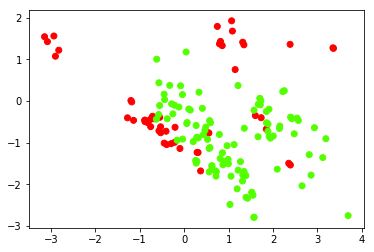

In [44]:
from functools import reduce
reference_frames = detections[:1877]
arr_reference = np.array([ [d[1]] + list(d[2]) for d in reduce(lambda x, y: x+y, [d[1] for d in reference_frames])])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(arr_reference)
X_std = scaler.transform(arr_reference)

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
pca_matrix = sklearn_pca.fit(X_std)
Y_reference = pca_matrix.transform(X_std)

failed_frames = detections[2248:2328]
arr_detections = np.array([ [d[1]] + list(d[2]) for d in reduce(lambda x, y: x+y, [d[1] for d in failed_frames])])

X_std = scaler.transform(arr_detections)
Y_detection = pca_matrix.transform(X_std)

Y = np.vstack((Y_reference, Y_detection))
colors = np.hstack((np.repeat(0, Y_reference.shape[0]), np.repeat(1, Y_detection.shape[0])))
plt.scatter(Y[:,0], Y[:,1], c=colors, cmap=plt.cm.get_cmap('prism', 10))

In [34]:
def plot_detections(img, detection):
    for d in detection:
        score = '%.2f' % d[1]
        (xc, yc, w, h) = map(int, d[2])
        img = cv2.rectangle(img,(xc-w//2,yc-h//2),(xc+w//2,yc+w//2),(0,255,0),3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        img = cv2.putText(img,score,(xc-w//2,yc-h//2-10), font, 1,(255,0,0),3,cv2.LINE_AA)
    plt.imshow(img)

#### These are all the pictures with false postives overlaid on top.

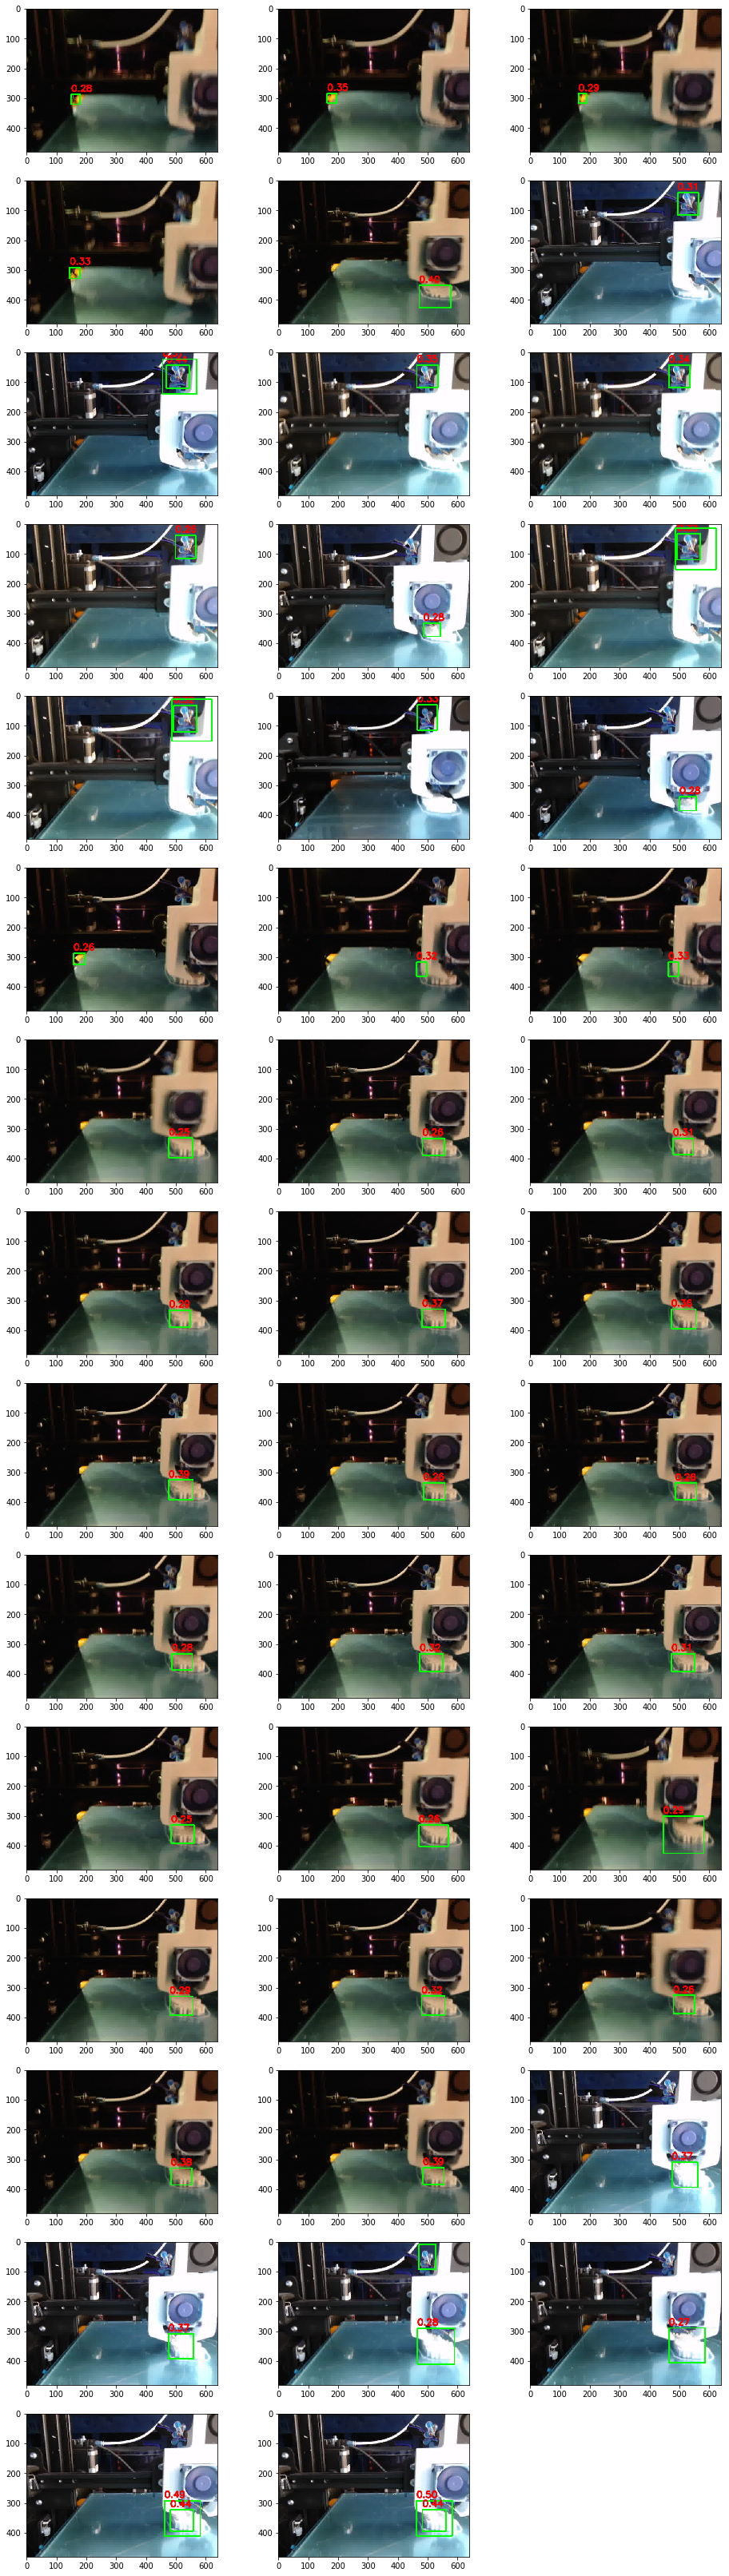

In [35]:
detected_frames = [d for d in detections[:1877] if len(d[1]) > 0]

fig=plt.figure(figsize=(16, 16*len(detected_frames)/12))
    
for i, (img_file, d) in enumerate(detected_frames):
    img = cv2.imread(img_file)
    fig.add_subplot(len(detected_frames)/3+1, 3, i+1)
    plot_detections(img, d)
plt.show()


#### These are the pictures with real failures. They are obviously very different from false positive detections.

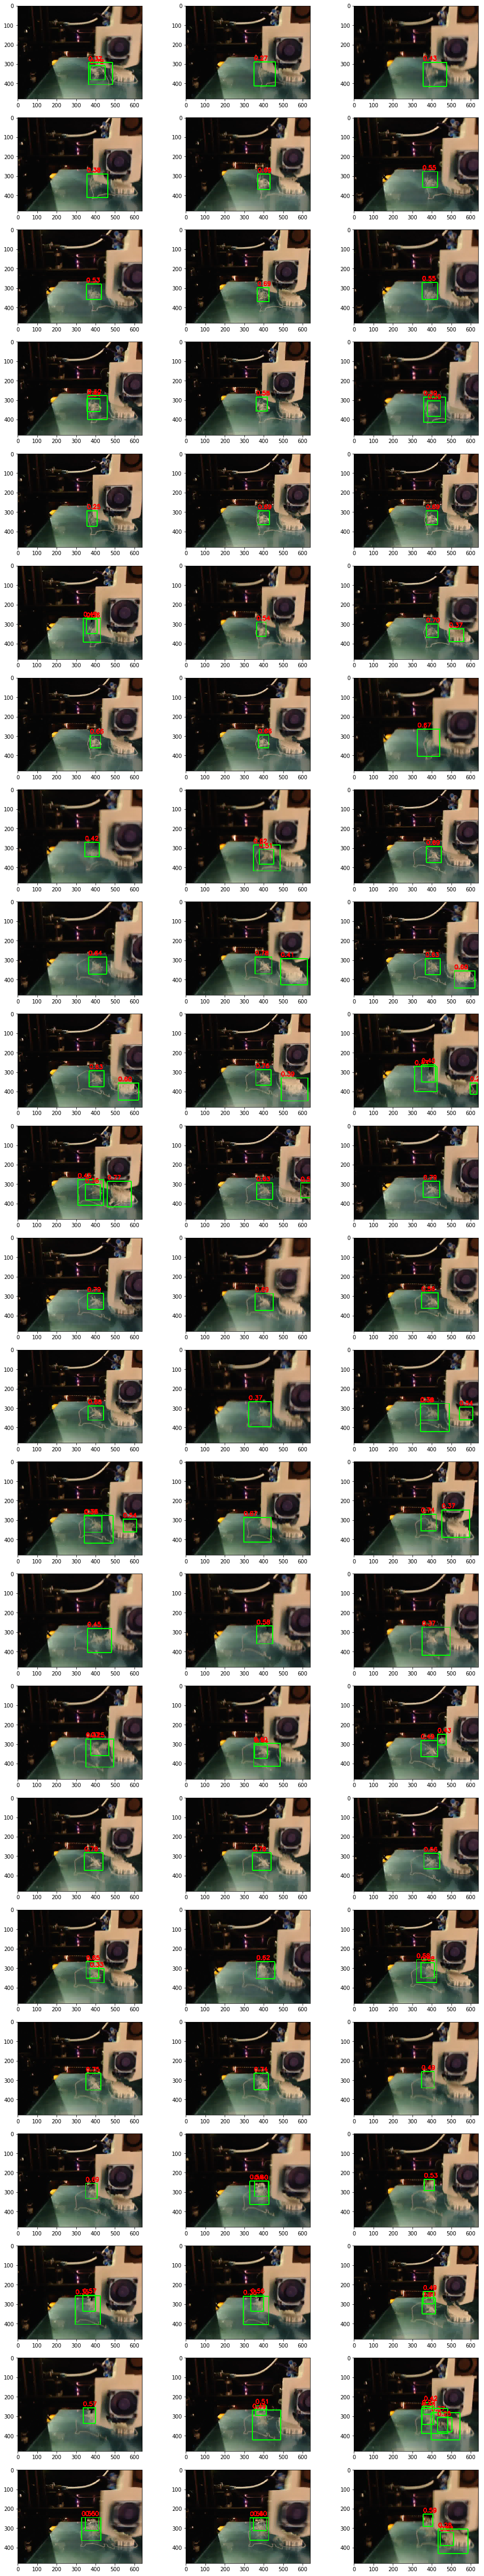

In [45]:
detected_frames = [d for d in detections[2248:2328] if len(d[1]) > 0]

fig=plt.figure(figsize=(16, 16*len(detected_frames)/12))
    
for i, (img_file, d) in enumerate(detected_frames):
    img = cv2.imread(img_file)
    fig.add_subplot(len(detected_frames)/3+1, 3, i+1)
    plot_detections(img, d)
plt.show()
